In [2]:
import os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import curvedsky
import orphics
from orphics import maps, cosmology
from math import pi

import plancklens
from plancklens import utils, n0s
from plancklens import nhl
from plancklens.n1 import n1
from plancklens import qest, qecl, qresp

import pandas as pd
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['font.size']=12

In [3]:
exps_config = {
    'CMB_S4': {
        'nlev_t': 1,
        'nlev_p':2**0.5,
        'beam_arcmin': 1.4
    }
}


nlev_t = 1
nlev_p = 2**0.5
beam_arcmin = 1.4
lmax = 3000
ellmin = 30
ellmax = 3000
Lmax = 3000

# nlev_t = 30
# nlev_p = 55
# beam_arcmin = 1.4
# lmax = 3001
# ellmin = 30
# ellmax = 3000
# Lmax = ellmax



ls = np.arange(lmax+1)
ells = np.arange(ellmax+1)

In [4]:
theory = cosmology.default_theory()
cltt, clee, clbb = theory.lCl('TT', ls), theory.lCl('EE', ls), theory.lCl('BB', ls)
clte = theory.lCl('TE', ls)

A_cb_index = '07'
main_path = '/global/cscratch1/sd/hongbo/lens_rot_bias/'
cls_path = '/global/cscratch1/sd/hongbo/lens_rot_bias/inputPs'

In [5]:
claa = np.loadtxt(cls_path + '/claa_A1e-%s.txt' %A_cb_index)[:,1]
# claa[1] = 0

In [6]:
clpp = np.loadtxt(cls_path + '/cosmo2017_10K_acc3_lenspotentialCls.dat', \
                  usecols=(5), unpack=True)
fac = (ls*(ls+1))**2/(2*pi)
fac[0] = 1
clpp = np.concatenate(([1,1], clpp))[ls]/fac
clpp[0], clpp[1] = 0, 0

In [7]:
nltt = (nlev_t*pi/180/60)**2/maps.gauss_beam(ls, beam_arcmin)**2
nlee = (nlev_p*pi/180/60)**2/maps.gauss_beam(ls, beam_arcmin)**2
nlbb = nlee

ocltt = cltt + nltt
oclee = clee + nlee
oclbb = clbb + nlbb
oclee[0], oclee[1], oclbb[0], oclbb[1] = 1, 1, 1, 1

In [8]:
nl_eb = curvedsky.norm_quad.qeb('lens', ellmax, ellmin, ellmax, clee[:ellmax+1],\
                                        oclee[:ellmax+1], oclbb[:ellmax+1], lfac='')[0]
Al_eb = nl_eb * ells**2

In [9]:
# import solenspipe
# from falafel import qe,utils
# ucls,tcls = utils.get_theory_dicts(grad=True)

# bh,ells,Als,R_src_tt,Nl_g,Nl_c,Nl_g_bh = solenspipe.get_tempura_norms('EB',
#                                                                 'EB',ucls,tcls, \
#                                                                 ellmin,ellmax,ellmax)

# plt.plot(ls[2:], (fac*clpp)[2:], label='clpp')
# plt.plot(ls[2:], (fac*nl_eb)[2:], label='N0, cmblensplus')
# # for noiseless map
# plt.plot(ls[2:], (fac*(4*Nl_g/(ls*(ls+1))**2))[2:], label='N0, solenspipe')
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()

# firstly calculate unormalized uN1aa

In [10]:
ftl = 1/ocltt[:lmax+1]
fel = 1/oclee[:lmax+1]
fbl = 1/oclbb[:lmax+1]

# ftl[:ellmin] *= 0.
# fel[:ellmin] *= 0.
# fbl[:ellmin] *= 0.

ftl[:2] *= 0.
fel[:2] *= 0.
fbl[:2] *= 0.

In [11]:
#---- N1 lensing bias library:
n1_dd = n1.library_n1(main_path+'/notebooks_new/',cltt,clte,clee)

In [12]:
n1aa = n1_dd.get_n1('peb', 'r', claa[:4001], ftl, fel, fbl, ellmax)

In [13]:
# n1pp = n1_dd.get_n1('peb', 'p', clpp, ftl, fel, fbl, ellmax)

In [14]:
# Ls = np.concatenate([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], np.arange(1, ellmax + 1)[::20], [ellmax]])
Ls = np.arange(5, ellmax+1, 20)

/global/u2/h/hongbo/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


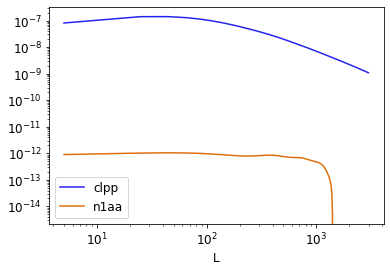

In [15]:
plt.plot(Ls, fac[Ls]*(clpp)[Ls], label='clpp')
plt.plot(Ls, fac[Ls]*((Al_eb/ells**2)**2)[Ls]*n1aa[Ls], label='n1aa')
# plt.plot(Ls, fac[Ls]*((Al_eb/ells**2)**2)[Ls]*n1pp[Ls], label='n1pp')
plt.legend()
plt.xlabel('L')
plt.xscale('log')
plt.yscale('log')

/global/u2/h/hongbo/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


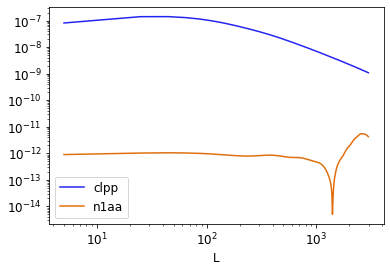

In [16]:
plt.plot(Ls, fac[Ls]*(clpp)[Ls], label='clpp')
plt.plot(Ls, np.abs(fac[Ls]*((Al_eb/ells**2)**2)[Ls]*n1aa[Ls]), label='n1aa')
# plt.plot(Ls, np.abs(fac[Ls]*((Al_eb/ells**2)**2)[Ls]*n1pp[Ls]), label='n1pp')
plt.legend()
plt.xlabel('L')
plt.xscale('log')
plt.yscale('log')

In [17]:
# Then calcute the correct Al_eb

In [18]:
# data = pd.read_csv(main_path + 'notebooks/CMB_S4_30_3000_n.csv')
# bias = ((data['EB_rot_reckap_x_reckap']-data['EB_reckap_x_reckap'])-(data['EB_rot_rdn0']-data['EB_rdn0']))/\
#                  data['EB_inkap_x_inkap']
data = np.loadtxt(main_path + 'notebooks_new/paper_data.txt')

/global/u2/h/hongbo/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


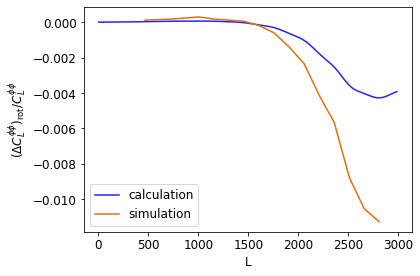

In [19]:
plt.plot(Ls, ((Al_eb/ells**2)**2)[Ls]*n1aa[Ls]/clpp[Ls], label='calculation')
# plt.plot(data['L'], bias, label='simulation')
plt.plot(data[:, 0], data[:, 1], label='simulation')
plt.legend()
plt.xlabel('L')
plt.ylabel('$({\Delta}C_L^{\phi \phi})_{\mathrm{rot}}/C_L^{\phi \phi}$')
plt.tight_layout()
plt.savefig(main_path + '/notebooks_new/compare.png')

In [20]:
A_cb = 1e-06

result_nums = [90, 110, 130, 150, 170]
n1aa_integral = []
for result_num in result_nums:
    n1aa_integral.append(np.loadtxt(main_path+'/output/N1aa/N1aa_%s_%s_CMB_S4_30_3000.dat' %(result_num, A_cb)))

n1aa_integral = np.array(n1aa_integral)
n1aa_sim = np.mean(n1aa_integral, axis=0)

/global/u2/h/hongbo/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


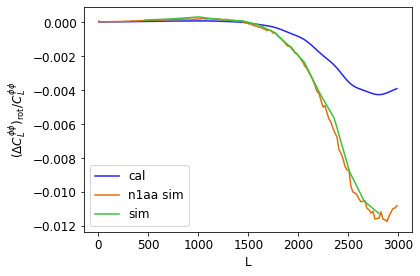

In [23]:
plt.plot(Ls, ((Al_eb/ells**2)**2)[Ls]*n1aa[Ls]/clpp[Ls], label='cal')
plt.plot(Ls, n1aa_sim[Ls]/clpp[Ls]/10, label='n1aa sim')
plt.plot(data[:, 0], data[:, 1], label='sim')
# plt.plot(data['L'], bias, label='simulation')
plt.legend()
plt.xlabel('L')
plt.ylabel('$({\Delta}C_L^{\phi \phi})_{\mathrm{rot}}/C_L^{\phi \phi}$')
plt.tight_layout()
plt.savefig(main_path + '/notebooks_new/compare.png')